In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

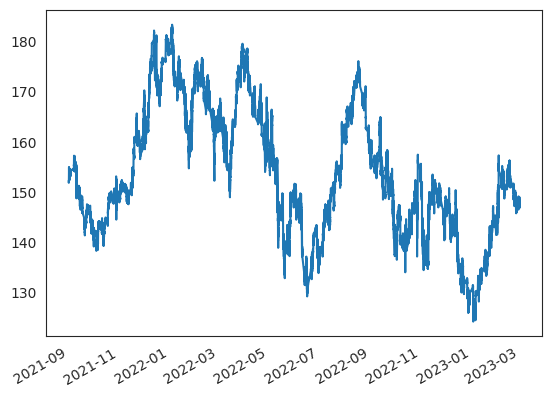

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,151.953148,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,1,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.024518,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,1,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.079614,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.649316,27.633299,69.132130,12.694655,18.306713,151.598286,152.246714,0.004268,151.436178,152.408822,0.006402,151.645288,152.092112,0.0029

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_13388051396.1535_target.csv",
#     top_n=25,
#     spread=10.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 15, 50)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 60), 100)
    vol_thresh       = trial.suggest_float("vol_thresh", 2.5, 5.0)
    adx_thresh       = trial.suggest_float("adx_thresh", 50.0, 60.0)
    atr_mult         = trial.suggest_float("atr_mult", 0.1, 5.0, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", -20.0, 5.0)
    buy_factor       = trial.suggest_float("buy_factor", 0.2, 1.0)
    sell_factor      = trial.suggest_float("sell_factor", 0.2, 1.0)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 2.0, 20.0)
    sign_thresh_pair = trial.suggest_categorical("tc_pair",[ # "ema_3|ema_8",
                                                    # "ema_5|ema_13"
                                                    "ema_9|ema_21",
                                                    "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            # sess_start      = params.sess_start_tick
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


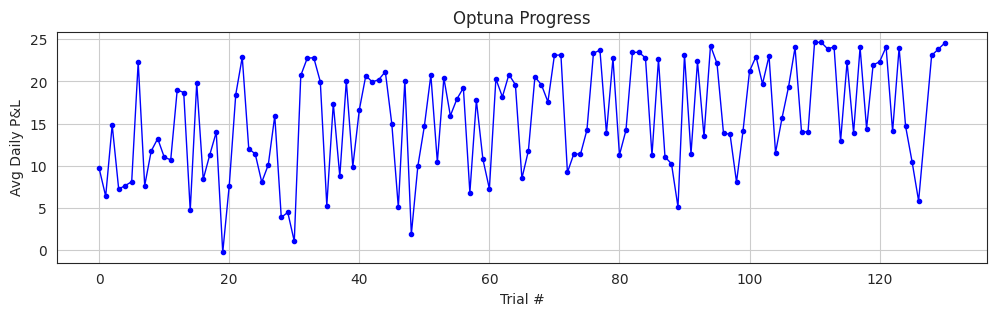

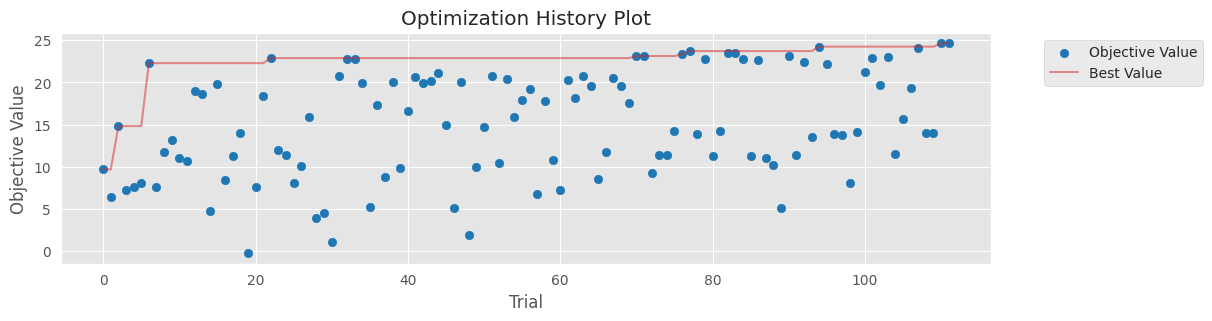

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=87; vol_thresh=4.67286894883579; adx_thresh=54.245449543879964; atr_mult=1.7415874857446658; vwap_atr_mult=3.413864961889466; buy_factor=0.5352905869646183; sell_factor=0.6158574392892888; trailstop_pct=16.884676771896928; tc_pair=ema_21|ema_50


Trial 0: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:0.9251 mean_bh:-8.7491 mean_excess:9.6742 improv_vs_bh:110.57%
Action counts: {'Buy': 23, 'Sell': 112, 'Hold': 350576}
Best trial is: 0 with best_val: 9.6742
[save_results] wrote optuna_results/AAPL_9.6742_predicted.csv
[save_best_json] wrote optuna_results/AAPL_9.6742_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=65; vol_thresh=2.7212784652671296; adx_thresh=53.07732294362296; atr_mult=0.538007092091042; vwap_atr_mult=-12.545263144919915; buy_factor=0.33104054883438955; sell_factor=0.6043796063953331; trailstop_pct=14.279517158483785; tc_pair=ema_9|ema_21


Trial 1: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:-2.3751 mean_bh:-8.7491 mean_excess:6.3740 improv_vs_bh:72.85%
Action counts: {'Buy': 119, 'Sell': 489, 'Hold': 350103}
Best trial is: 0 with best_val: 9.6742
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=96; vol_thresh=2.971751692238121; adx_thresh=58.738599316809065; atr_mult=0.6925778000186509; vwap_atr_mult=1.1728573086667353; buy_factor=0.7821576362460148; sell_factor=0.9085483734849966; trailstop_pct=2.307517365773114; tc_pair=ema_9|ema_21


Trial 2: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:6.0726 mean_bh:-8.7491 mean_excess:14.8217 improv_vs_bh:169.41%
Action counts: {'Buy': 36, 'Sell': 87, 'Hold': 350588}
Best trial is: 2 with best_val: 14.8217
[save_results] wrote optuna_results/AAPL_14.8217_predicted.csv
[save_best_json] wrote optuna_results/AAPL_14.8217_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=66; vol_thresh=4.246542212052635; adx_thresh=51.130838317882066; atr_mult=1.8400540941961323; vwap_atr_mult=-3.9337873239268006; buy_factor=0.7535672095292987; sell_factor=0.5988127548754401; trailstop_pct=2.735522264743997; tc_pair=ema_9|ema_21


Trial 3: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:-1.5202 mean_bh:-8.7491 mean_excess:7.2289 improv_vs_bh:82.62%
Action counts: {'Buy': 46, 'Sell': 259, 'Hold': 350406}
Best trial is: 2 with best_val: 14.8217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=62; vol_thresh=4.276303357506815; adx_thresh=57.075061133731786; atr_mult=3.1485317191288194; vwap_atr_mult=1.8659094101014766; buy_factor=0.42105250162807; sell_factor=0.7275451838557432; trailstop_pct=11.471054763620518; tc_pair=ema_9|ema_21


Trial 4: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:-1.1132 mean_bh:-8.7491 mean_excess:7.6359 improv_vs_bh:87.28%
Action counts: {'Buy': 16, 'Sell': 67, 'Hold': 350628}
Best trial is: 2 with best_val: 14.8217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=94; vol_thresh=4.206770193905052; adx_thresh=52.73367645669741; atr_mult=0.41327248906537045; vwap_atr_mult=-10.952404560577069; buy_factor=0.7524090692979093; sell_factor=0.668264679712929; trailstop_pct=10.526056986020558; tc_pair=ema_9|ema_21


Trial 5: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:-0.6503 mean_bh:-8.7491 mean_excess:8.0988 improv_vs_bh:92.57%
Action counts: {'Buy': 41, 'Sell': 205, 'Hold': 350465}
Best trial is: 2 with best_val: 14.8217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=74; vol_thresh=3.616833607065585; adx_thresh=57.517468670813045; atr_mult=3.5921161555412424; vwap_atr_mult=-1.8516399252235338; buy_factor=0.9332503026647019; sell_factor=0.5523795586594604; trailstop_pct=19.324910957079364; tc_pair=ema_21|ema_50


Trial 6: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:13.5338 mean_bh:-8.7491 mean_excess:22.2828 improv_vs_bh:254.69%
Action counts: {'Buy': 26, 'Sell': 152, 'Hold': 350533}
Best trial is: 6 with best_val: 22.2828
[save_results] wrote optuna_results/AAPL_22.2828_predicted.csv
[save_best_json] wrote optuna_results/AAPL_22.2828_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=48; rsi_max_thresh=90; vol_thresh=4.933632084424409; adx_thresh=52.33285248039279; atr_mult=4.5290301384306995; vwap_atr_mult=-10.170225431535; buy_factor=0.7279293460094234; sell_factor=0.4622299679153482; trailstop_pct=17.390246611697762; tc_pair=ema_21|ema_50


Trial 7: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:-1.1179 mean_bh:-8.7491 mean_excess:7.6312 improv_vs_bh:87.22%
Action counts: {'Buy': 26, 'Sell': 230, 'Hold': 350455}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=94; vol_thresh=3.8097181448802684; adx_thresh=51.418790177676996; atr_mult=0.37050878219014904; vwap_atr_mult=-5.073820352737076; buy_factor=0.4409382103104682; sell_factor=0.22883881052912827; trailstop_pct=3.885162590798168; tc_pair=ema_9|ema_21


Trial 8: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:2.9896 mean_bh:-8.7491 mean_excess:11.7387 improv_vs_bh:134.17%
Action counts: {'Buy': 58, 'Sell': 806, 'Hold': 349847}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=94; vol_thresh=4.272776518068611; adx_thresh=54.270079067305346; atr_mult=0.18338836732658836; vwap_atr_mult=-11.371400869692875; buy_factor=0.9473285195017469; sell_factor=0.3440916650853152; trailstop_pct=12.698856235160205; tc_pair=ema_9|ema_21


Trial 9: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:4.4616 mean_bh:-8.7491 mean_excess:13.2106 improv_vs_bh:150.99%
Action counts: {'Buy': 29, 'Sell': 315, 'Hold': 350367}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; vol_thresh=3.303759035987416; adx_thresh=59.88697730064865; atr_mult=0.10168898490219357; vwap_atr_mult=-19.37363896406951; buy_factor=0.9986181421020005; sell_factor=0.9853957821188792; trailstop_pct=19.37988047952819; tc_pair=ema_21|ema_50


Trial 10: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:2.2737 mean_bh:-8.7491 mean_excess:11.0228 improv_vs_bh:125.99%
Action counts: {'Buy': 19, 'Sell': 38, 'Hold': 350654}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=80; vol_thresh=3.0288694841536703; adx_thresh=57.55739518578566; atr_mult=1.0209013761580028; vwap_atr_mult=-0.918801231271992; buy_factor=0.8720428061114818; sell_factor=0.9075139294978573; trailstop_pct=7.356934697263661; tc_pair=ema_21|ema_50


Trial 11: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:1.9347 mean_bh:-8.7491 mean_excess:10.6837 improv_vs_bh:122.11%
Action counts: {'Buy': 45, 'Sell': 99, 'Hold': 350567}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=73; vol_thresh=3.4517396967469773; adx_thresh=57.724217169206625; atr_mult=1.4474676848038128; vwap_atr_mult=-1.30249486885279; buy_factor=0.840107814978539; sell_factor=0.8027215925695745; trailstop_pct=7.0669384904315775; tc_pair=ema_21|ema_50


Trial 12: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:10.2358 mean_bh:-8.7491 mean_excess:18.9849 improv_vs_bh:216.99%
Action counts: {'Buy': 30, 'Sell': 88, 'Hold': 350593}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=74; vol_thresh=3.5069980986112994; adx_thresh=56.25167303950826; atr_mult=1.8415607298215102; vwap_atr_mult=-2.3479450025749085; buy_factor=0.6338937782589523; sell_factor=0.7942594829657601; trailstop_pct=7.414748856353661; tc_pair=ema_21|ema_50


Trial 13: 100%|██████████| 375/375 [00:20<00:00, 18.53it/s]


[Results] mean_pnl:9.9316 mean_bh:-8.7491 mean_excess:18.6807 improv_vs_bh:213.52%
Action counts: {'Buy': 33, 'Sell': 97, 'Hold': 350581}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=71; vol_thresh=3.6579360386021613; adx_thresh=55.999171932357164; atr_mult=4.80723665450591; vwap_atr_mult=4.961329455400216; buy_factor=0.8833734598833153; sell_factor=0.4760093196182583; trailstop_pct=7.6704119517798635; tc_pair=ema_21|ema_50


Trial 14: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:-4.0511 mean_bh:-8.7491 mean_excess:4.6980 improv_vs_bh:53.70%
Action counts: {'Buy': 24, 'Sell': 180, 'Hold': 350507}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=81; vol_thresh=3.8843720177598424; adx_thresh=58.34492421673148; atr_mult=1.0133629527839967; vwap_atr_mult=-6.908613528988941; buy_factor=0.8703093567778959; sell_factor=0.7847713914537119; trailstop_pct=5.19667123051584; tc_pair=ema_21|ema_50


Trial 15: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:11.0592 mean_bh:-8.7491 mean_excess:19.8083 improv_vs_bh:226.40%
Action counts: {'Buy': 21, 'Sell': 79, 'Hold': 350611}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=81; vol_thresh=3.9291479486988115; adx_thresh=59.270627450227735; atr_mult=3.030116487493767; vwap_atr_mult=-7.754073556984559; buy_factor=0.21463143171421473; sell_factor=0.48707890781206786; trailstop_pct=4.828210970764746; tc_pair=ema_21|ema_50


Trial 16: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:-0.3631 mean_bh:-8.7491 mean_excess:8.3860 improv_vs_bh:95.85%
Action counts: {'Buy': 16, 'Sell': 98, 'Hold': 350597}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=82; vol_thresh=3.9104750058165783; adx_thresh=58.43946130111048; atr_mult=1.1701277627465865; vwap_atr_mult=-16.649419909246564; buy_factor=0.638863988686753; sell_factor=0.7616689208673781; trailstop_pct=19.909979567275702; tc_pair=ema_21|ema_50


Trial 17: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:2.5279 mean_bh:-8.7491 mean_excess:11.2770 improv_vs_bh:128.89%
Action counts: {'Buy': 20, 'Sell': 74, 'Hold': 350617}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=85; vol_thresh=3.164751508997722; adx_thresh=55.655362722937056; atr_mult=0.23533906961468157; vwap_atr_mult=-6.596432618583963; buy_factor=0.9386466506158797; sell_factor=0.5299015459351839; trailstop_pct=14.525597222667157; tc_pair=ema_21|ema_50


Trial 18: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:5.2175 mean_bh:-8.7491 mean_excess:13.9666 improv_vs_bh:159.63%
Action counts: {'Buy': 51, 'Sell': 290, 'Hold': 350370}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=69; vol_thresh=4.561812939953098; adx_thresh=56.79065920542263; atr_mult=3.1153708911219797; vwap_atr_mult=-7.98133926788631; buy_factor=0.9864163126434258; sell_factor=0.3663503380810813; trailstop_pct=9.175729065025845; tc_pair=ema_21|ema_50


Trial 19: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:-9.0143 mean_bh:-8.7491 mean_excess:-0.2652 improv_vs_bh:-3.03%
Action counts: {'Buy': 12, 'Sell': 143, 'Hold': 350556}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=100; vol_thresh=2.779558271543531; adx_thresh=54.92284098546172; atr_mult=0.9524017964716012; vwap_atr_mult=-4.151662811721348; buy_factor=0.6893493052495799; sell_factor=0.7043554749354126; trailstop_pct=4.704371922519269; tc_pair=ema_21|ema_50


Trial 20: 100%|██████████| 375/375 [00:19<00:00, 18.87it/s]


[Results] mean_pnl:-1.1067 mean_bh:-8.7491 mean_excess:7.6424 improv_vs_bh:87.35%
Action counts: {'Buy': 91, 'Sell': 310, 'Hold': 350310}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=76; vol_thresh=3.3931192166476225; adx_thresh=57.766526047317214; atr_mult=1.3879184739811312; vwap_atr_mult=-0.5485133358635792; buy_factor=0.8461454394480478; sell_factor=0.8101503806230955; trailstop_pct=5.909109032278509; tc_pair=ema_21|ema_50


Trial 21: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:9.6764 mean_bh:-8.7491 mean_excess:18.4254 improv_vs_bh:210.60%
Action counts: {'Buy': 31, 'Sell': 92, 'Hold': 350588}
Best trial is: 6 with best_val: 22.2828
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=77; vol_thresh=3.6402645686801414; adx_thresh=58.26758047114948; atr_mult=2.516316326922662; vwap_atr_mult=-1.3606235658554198; buy_factor=0.8302574212000843; sell_factor=0.8652978851781263; trailstop_pct=9.481760635111142; tc_pair=ema_21|ema_50


Trial 22: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:14.1320 mean_bh:-8.7491 mean_excess:22.8810 improv_vs_bh:261.52%
Action counts: {'Buy': 25, 'Sell': 72, 'Hold': 350614}
Best trial is: 22 with best_val: 22.8810
[save_results] wrote optuna_results/AAPL_22.881_predicted.csv
[save_best_json] wrote optuna_results/AAPL_22.881_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=78; vol_thresh=3.625364146414616; adx_thresh=59.971203576560704; atr_mult=2.3953306724246812; vwap_atr_mult=-3.3371168869921313; buy_factor=0.8071088933302388; sell_factor=0.9486973258876036; trailstop_pct=9.399754725869123; tc_pair=ema_21|ema_50


Trial 23: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:3.2827 mean_bh:-8.7491 mean_excess:12.0318 improv_vs_bh:137.52%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=84; vol_thresh=4.066632428319717; adx_thresh=58.38415929179518; atr_mult=2.4181267473066153; vwap_atr_mult=-5.983244550184924; buy_factor=0.8772099497542716; sell_factor=0.8541379505565413; trailstop_pct=13.636307999927507; tc_pair=ema_21|ema_50


Trial 24: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:2.6301 mean_bh:-8.7491 mean_excess:11.3792 improv_vs_bh:130.06%
Action counts: {'Buy': 19, 'Sell': 60, 'Hold': 350632}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=77; vol_thresh=3.8303107220440595; adx_thresh=59.06783331312748; atr_mult=0.7782740256042926; vwap_atr_mult=0.37277732731268953; buy_factor=0.9172033298778232; sell_factor=0.8646313405722128; trailstop_pct=9.20650951559971; tc_pair=ema_21|ema_50


Trial 25: 100%|██████████| 375/375 [00:21<00:00, 17.58it/s]


[Results] mean_pnl:-0.7105 mean_bh:-8.7491 mean_excess:8.0386 improv_vs_bh:91.88%
Action counts: {'Buy': 17, 'Sell': 52, 'Hold': 350642}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=70; vol_thresh=3.612205080248965; adx_thresh=50.1557245417441; atr_mult=3.8421638353204717; vwap_atr_mult=-14.625239546481186; buy_factor=0.5322821295199021; sell_factor=0.6751674671660789; trailstop_pct=16.036911830154178; tc_pair=ema_21|ema_50


Trial 26: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:1.3480 mean_bh:-8.7491 mean_excess:10.0971 improv_vs_bh:115.41%
Action counts: {'Buy': 79, 'Sell': 312, 'Hold': 350320}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=88; vol_thresh=3.2295722272428176; adx_thresh=56.67430086267626; atr_mult=2.426749244877451; vwap_atr_mult=-9.58588748138505; buy_factor=0.6930386506357897; sell_factor=0.40943792536561274; trailstop_pct=12.255984305511587; tc_pair=ema_21|ema_50


Trial 27: 100%|██████████| 375/375 [00:20<00:00, 18.36it/s]


[Results] mean_pnl:7.1638 mean_bh:-8.7491 mean_excess:15.9129 improv_vs_bh:181.88%
Action counts: {'Buy': 41, 'Sell': 314, 'Hold': 350356}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=79; vol_thresh=4.001199402158036; adx_thresh=58.04062481899439; atr_mult=3.722271010350348; vwap_atr_mult=2.216290940107646; buy_factor=0.811989809395341; sell_factor=0.5773032718194521; trailstop_pct=5.659409001472848; tc_pair=ema_21|ema_50


Trial 28: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:-4.8857 mean_bh:-8.7491 mean_excess:3.8634 improv_vs_bh:44.16%
Action counts: {'Buy': 19, 'Sell': 99, 'Hold': 350593}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=84; vol_thresh=2.5130618961257722; adx_thresh=55.52721800153985; atr_mult=1.8699706515502994; vwap_atr_mult=-2.2053927031615714; buy_factor=0.5925119955061703; sell_factor=0.6363719724700478; trailstop_pct=16.219731850005267; tc_pair=ema_21|ema_50


Trial 29: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:-4.2865 mean_bh:-8.7491 mean_excess:4.4625 improv_vs_bh:51.01%
Action counts: {'Buy': 112, 'Sell': 420, 'Hold': 350179}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=72; vol_thresh=4.498533640311873; adx_thresh=59.297256523234815; atr_mult=1.3675908582103604; vwap_atr_mult=3.6921728227357153; buy_factor=0.9199914297188865; sell_factor=0.543032951612638; trailstop_pct=10.252691191415444; tc_pair=ema_21|ema_50


Trial 30: 100%|██████████| 375/375 [00:20<00:00, 18.59it/s]


[Results] mean_pnl:-7.7217 mean_bh:-8.7491 mean_excess:1.0274 improv_vs_bh:11.74%
Action counts: {'Buy': 13, 'Sell': 88, 'Hold': 350610}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=73; vol_thresh=3.5341664659026883; adx_thresh=57.33065717196297; atr_mult=1.3487096301631378; vwap_atr_mult=-1.234604896550474; buy_factor=0.8110520957063525; sell_factor=0.831775777284754; trailstop_pct=6.959988401099599; tc_pair=ema_21|ema_50


Trial 31: 100%|██████████| 375/375 [00:21<00:00, 17.29it/s]


[Results] mean_pnl:11.9524 mean_bh:-8.7491 mean_excess:20.7015 improv_vs_bh:236.61%
Action counts: {'Buy': 29, 'Sell': 84, 'Hold': 350598}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=66; vol_thresh=3.7181778477214156; adx_thresh=57.299557865901534; atr_mult=0.7397572295003649; vwap_atr_mult=-5.11996185478794; buy_factor=0.958806011056432; sell_factor=0.8450424150285725; trailstop_pct=5.993317261808989; tc_pair=ema_21|ema_50


Trial 32: 100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


[Results] mean_pnl:14.0169 mean_bh:-8.7491 mean_excess:22.7660 improv_vs_bh:260.21%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=67; vol_thresh=3.6848353832435223; adx_thresh=57.14614232496636; atr_mult=0.5244157312124044; vwap_atr_mult=-2.391166605828772; buy_factor=0.9618148784769001; sell_factor=0.8587457707029287; trailstop_pct=8.752547008524294; tc_pair=ema_21|ema_50


Trial 33: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:14.0495 mean_bh:-8.7491 mean_excess:22.7986 improv_vs_bh:260.58%
Action counts: {'Buy': 23, 'Sell': 76, 'Hold': 350612}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=60; vol_thresh=3.741942318407127; adx_thresh=54.706713008710764; atr_mult=0.5000316173969562; vwap_atr_mult=-3.2770034936462555; buy_factor=0.9638869407892677; sell_factor=0.8907796709373198; trailstop_pct=8.738244176361977; tc_pair=ema_21|ema_50


Trial 34: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:11.2223 mean_bh:-8.7491 mean_excess:19.9714 improv_vs_bh:228.27%
Action counts: {'Buy': 39, 'Sell': 93, 'Hold': 350579}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=66; vol_thresh=4.1118463428653085; adx_thresh=56.53449514289073; atr_mult=0.6606176222018695; vwap_atr_mult=0.49095289588728264; buy_factor=0.9217486198253629; sell_factor=0.9964119925189423; trailstop_pct=8.322950914348073; tc_pair=ema_9|ema_21


Trial 35: 100%|██████████| 375/375 [00:21<00:00, 17.80it/s]


[Results] mean_pnl:-3.4725 mean_bh:-8.7491 mean_excess:5.2766 improv_vs_bh:60.31%
Action counts: {'Buy': 20, 'Sell': 36, 'Hold': 350655}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=68; vol_thresh=3.3760521981377747; adx_thresh=57.14373274021165; atr_mult=0.3134599619038545; vwap_atr_mult=-5.088720238926534; buy_factor=0.9626048641728022; sell_factor=0.739844677976037; trailstop_pct=3.259409762256632; tc_pair=ema_21|ema_50


Trial 36: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:8.6249 mean_bh:-8.7491 mean_excess:17.3740 improv_vs_bh:198.58%
Action counts: {'Buy': 28, 'Sell': 120, 'Hold': 350563}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=64; vol_thresh=3.1080833810974045; adx_thresh=53.485885557476294; atr_mult=0.5251126980539079; vwap_atr_mult=2.6447963180634693; buy_factor=0.998694043464912; sell_factor=0.9427005859537841; trailstop_pct=11.433886581208743; tc_pair=ema_9|ema_21


Trial 37: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:-0.0130 mean_bh:-8.7491 mean_excess:8.7361 improv_vs_bh:99.85%
Action counts: {'Buy': 47, 'Sell': 141, 'Hold': 350523}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=67; vol_thresh=3.63507141111918; adx_thresh=55.44454512155537; atr_mult=0.6646511386464293; vwap_atr_mult=-5.296941808885411; buy_factor=0.7672908031982436; sell_factor=0.6404987407663657; trailstop_pct=10.291576986804747; tc_pair=ema_21|ema_50


Trial 38: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:11.2808 mean_bh:-8.7491 mean_excess:20.0299 improv_vs_bh:228.94%
Action counts: {'Buy': 38, 'Sell': 170, 'Hold': 350503}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=63; vol_thresh=3.786897914252405; adx_thresh=58.78315272125022; atr_mult=0.2778995941714835; vwap_atr_mult=-2.557754788319975; buy_factor=0.8893902826482522; sell_factor=0.9476200480020764; trailstop_pct=2.0971145203650225; tc_pair=ema_9|ema_21


Trial 39: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:1.1376 mean_bh:-8.7491 mean_excess:9.8867 improv_vs_bh:113.00%
Action counts: {'Buy': 21, 'Sell': 48, 'Hold': 350642}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=61; vol_thresh=2.9015778769125458; adx_thresh=57.0403695552191; atr_mult=0.45537605541745735; vwap_atr_mult=1.0153598737046088; buy_factor=0.9145959837548425; sell_factor=0.7100968478858958; trailstop_pct=18.31613396747835; tc_pair=ema_21|ema_50


Trial 40: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:7.8825 mean_bh:-8.7491 mean_excess:16.6315 improv_vs_bh:190.09%
Action counts: {'Buy': 46, 'Sell': 193, 'Hold': 350472}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=71; vol_thresh=3.5345310232243587; adx_thresh=57.377659100494895; atr_mult=0.8437469091194778; vwap_atr_mult=-1.188089026523548; buy_factor=0.8058968168228002; sell_factor=0.8370468286612232; trailstop_pct=6.3270649157897045; tc_pair=ema_21|ema_50


Trial 41: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:11.9354 mean_bh:-8.7491 mean_excess:20.6845 improv_vs_bh:236.42%
Action counts: {'Buy': 29, 'Sell': 84, 'Hold': 350598}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=75; vol_thresh=3.2841772256389525; adx_thresh=58.04736678791409; atr_mult=2.046578021984945; vwap_atr_mult=-4.185800511393124; buy_factor=0.833025650095498; sell_factor=0.8848526514305829; trailstop_pct=6.234956457612512; tc_pair=ema_21|ema_50


Trial 42: 100%|██████████| 375/375 [00:21<00:00, 17.52it/s]


[Results] mean_pnl:11.1739 mean_bh:-8.7491 mean_excess:19.9230 improv_vs_bh:227.71%
Action counts: {'Buy': 34, 'Sell': 73, 'Hold': 350604}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=50; rsi_max_thresh=65; vol_thresh=3.718851300243179; adx_thresh=56.18482942522129; atr_mult=0.6576304753707594; vwap_atr_mult=-0.34150732843586784; buy_factor=0.773065666660293; sell_factor=0.8251181959712091; trailstop_pct=8.066787901338051; tc_pair=ema_21|ema_50


Trial 43: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:11.4751 mean_bh:-8.7491 mean_excess:20.2241 improv_vs_bh:231.16%
Action counts: {'Buy': 29, 'Sell': 88, 'Hold': 350594}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=73; vol_thresh=3.4886483705941824; adx_thresh=57.61575545252185; atr_mult=1.6173761160960036; vwap_atr_mult=-1.824640023280671; buy_factor=0.7234032891515668; sell_factor=0.9203009274112692; trailstop_pct=3.686386421997976; tc_pair=ema_21|ema_50


Trial 44: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:12.3977 mean_bh:-8.7491 mean_excess:21.1468 improv_vs_bh:241.70%
Action counts: {'Buy': 29, 'Sell': 60, 'Hold': 350622}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=69; vol_thresh=3.4229130245437296; adx_thresh=57.840941760437744; atr_mult=3.7226332753121; vwap_atr_mult=-2.1917648814562183; buy_factor=0.7064169603495537; sell_factor=0.9369244105559306; trailstop_pct=3.9628236200529785; tc_pair=ema_9|ema_21


Trial 45: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:6.1781 mean_bh:-8.7491 mean_excess:14.9271 improv_vs_bh:170.61%
Action counts: {'Buy': 31, 'Sell': 75, 'Hold': 350605}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=67; vol_thresh=4.201148903912779; adx_thresh=59.559926415148745; atr_mult=2.75594978014403; vwap_atr_mult=-4.215213684637443; buy_factor=0.735807201349861; sell_factor=0.23545679474816628; trailstop_pct=3.289199193914044; tc_pair=ema_21|ema_50


Trial 46: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:-3.7056 mean_bh:-8.7491 mean_excess:5.0435 improv_vs_bh:57.65%
Action counts: {'Buy': 15, 'Sell': 242, 'Hold': 350454}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=74; vol_thresh=3.5162039999293846; adx_thresh=58.73942418215145; atr_mult=1.6320040244591145; vwap_atr_mult=1.3675238330554116; buy_factor=0.8535493751627722; sell_factor=0.9106118498864312; trailstop_pct=12.465961739388344; tc_pair=ema_21|ema_50


Trial 47: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:11.3554 mean_bh:-8.7491 mean_excess:20.1045 improv_vs_bh:229.79%
Action counts: {'Buy': 25, 'Sell': 57, 'Hold': 350629}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=71; vol_thresh=4.852165196330735; adx_thresh=56.997547223936245; atr_mult=0.3578749510888358; vwap_atr_mult=-8.153159462798476; buy_factor=0.9563074094308835; sell_factor=0.7638226717992969; trailstop_pct=4.1118812561752085; tc_pair=ema_21|ema_50


Trial 48: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-6.8994 mean_bh:-8.7491 mean_excess:1.8497 improv_vs_bh:21.14%
Action counts: {'Buy': 9, 'Sell': 35, 'Hold': 350667}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=77; vol_thresh=4.366894946295875; adx_thresh=56.38095434044598; atr_mult=0.13073617781887875; vwap_atr_mult=-3.084994798620988; buy_factor=0.9018262091756719; sell_factor=0.9746626905378706; trailstop_pct=10.776836192823511; tc_pair=ema_21|ema_50


Trial 49: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:1.1955 mean_bh:-8.7491 mean_excess:9.9446 improv_vs_bh:113.66%
Action counts: {'Buy': 18, 'Sell': 30, 'Hold': 350663}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=63; vol_thresh=3.3282238653779816; adx_thresh=55.983845957087254; atr_mult=4.286351916247997; vwap_atr_mult=-5.778810651429517; buy_factor=0.5271871930373451; sell_factor=0.8668418503876065; trailstop_pct=6.920978490801415; tc_pair=ema_9|ema_21


Trial 50: 100%|██████████| 375/375 [00:20<00:00, 18.02it/s]


[Results] mean_pnl:5.9309 mean_bh:-8.7491 mean_excess:14.6800 improv_vs_bh:167.79%
Action counts: {'Buy': 45, 'Sell': 109, 'Hold': 350557}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=73; vol_thresh=3.5192687640503584; adx_thresh=57.30353207586084; atr_mult=2.128851635192553; vwap_atr_mult=-1.9372937445720522; buy_factor=0.7964276083839817; sell_factor=0.9113393530998409; trailstop_pct=6.771736944004086; tc_pair=ema_21|ema_50


Trial 51: 100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


[Results] mean_pnl:11.9942 mean_bh:-8.7491 mean_excess:20.7433 improv_vs_bh:237.09%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=73; vol_thresh=3.963620625753362; adx_thresh=58.231052991032115; atr_mult=2.1765823232021235; vwap_atr_mult=0.06566409036186882; buy_factor=0.9735655763215277; sell_factor=0.8893061216273145; trailstop_pct=9.77275099873572; tc_pair=ema_21|ema_50


Trial 52: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s]


[Results] mean_pnl:1.6826 mean_bh:-8.7491 mean_excess:10.4317 improv_vs_bh:119.23%
Action counts: {'Buy': 18, 'Sell': 48, 'Hold': 350645}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=76; vol_thresh=3.706704824327701; adx_thresh=57.48606291033135; atr_mult=1.1811728574652733; vwap_atr_mult=-1.850808803065822; buy_factor=0.6334913031613133; sell_factor=0.9169607234037329; trailstop_pct=5.225833594896217; tc_pair=ema_21|ema_50


Trial 53: 100%|██████████| 375/375 [00:17<00:00, 21.43it/s]


[Results] mean_pnl:11.6514 mean_bh:-8.7491 mean_excess:20.4004 improv_vs_bh:233.17%
Action counts: {'Buy': 26, 'Sell': 57, 'Hold': 350628}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=69; vol_thresh=3.80397902238705; adx_thresh=58.9346755699415; atr_mult=1.5841534692274697; vwap_atr_mult=-4.3542367379036895; buy_factor=0.752716189437417; sell_factor=0.7658397228698103; trailstop_pct=8.110151598877117; tc_pair=ema_21|ema_50


Trial 54: 100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


[Results] mean_pnl:7.1797 mean_bh:-8.7491 mean_excess:15.9288 improv_vs_bh:182.06%
Action counts: {'Buy': 21, 'Sell': 75, 'Hold': 350615}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=80; vol_thresh=3.5755848313261978; adx_thresh=58.53715536217608; atr_mult=2.7242142881790126; vwap_atr_mult=-3.226421608428498; buy_factor=0.3820188446594793; sell_factor=0.7942137580202456; trailstop_pct=2.7347254568813524; tc_pair=ema_21|ema_50


Trial 55: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:9.1479 mean_bh:-8.7491 mean_excess:17.8970 improv_vs_bh:204.56%
Action counts: {'Buy': 26, 'Sell': 76, 'Hold': 350609}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; vol_thresh=3.459151295921532; adx_thresh=57.644500727518604; atr_mult=3.4601264558238927; vwap_atr_mult=-1.493571993168577; buy_factor=0.9350001552911592; sell_factor=0.9740975645175793; trailstop_pct=4.720357417263591; tc_pair=ema_21|ema_50


Trial 56: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s]


[Results] mean_pnl:10.4881 mean_bh:-8.7491 mean_excess:19.2372 improv_vs_bh:219.88%
Action counts: {'Buy': 29, 'Sell': 44, 'Hold': 350638}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=72; vol_thresh=3.8673882457046354; adx_thresh=56.77717625874823; atr_mult=1.15098703829475; vwap_atr_mult=3.6255234157396075; buy_factor=0.841399902533637; sell_factor=0.5007748101470333; trailstop_pct=6.408560274031599; tc_pair=ema_21|ema_50


Trial 57: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:-1.9468 mean_bh:-8.7491 mean_excess:6.8023 improv_vs_bh:77.75%
Action counts: {'Buy': 20, 'Sell': 134, 'Hold': 350557}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=78; vol_thresh=3.200440321942469; adx_thresh=57.92497382620478; atr_mult=4.955441701099458; vwap_atr_mult=-6.6213966224013365; buy_factor=0.8693370151792528; sell_factor=0.6053852151834558; trailstop_pct=7.5150448946051736; tc_pair=ema_21|ema_50


Trial 58: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:9.0062 mean_bh:-8.7491 mean_excess:17.7553 improv_vs_bh:202.94%
Action counts: {'Buy': 37, 'Sell': 182, 'Hold': 350492}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=70; vol_thresh=3.0534310776668576; adx_thresh=55.770389933676434; atr_mult=2.941310111294516; vwap_atr_mult=-0.7037201134585105; buy_factor=0.9995460913114347; sell_factor=0.4209429184058264; trailstop_pct=14.2880767077583; tc_pair=ema_21|ema_50


Trial 59: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s]


[Results] mean_pnl:2.0355 mean_bh:-8.7491 mean_excess:10.7846 improv_vs_bh:123.27%
Action counts: {'Buy': 38, 'Sell': 445, 'Hold': 350228}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=82; vol_thresh=3.683746001746123; adx_thresh=59.630063899185906; atr_mult=0.5885707542068267; vwap_atr_mult=1.5979802450488023; buy_factor=0.7826387709366054; sell_factor=0.5616863444908208; trailstop_pct=11.456668459992882; tc_pair=ema_21|ema_50


Trial 60: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s]


[Results] mean_pnl:-1.4988 mean_bh:-8.7491 mean_excess:7.2503 improv_vs_bh:82.87%
Action counts: {'Buy': 19, 'Sell': 112, 'Hold': 350580}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=72; vol_thresh=3.5368402951042666; adx_thresh=57.276607356255376; atr_mult=2.0246859197828004; vwap_atr_mult=-1.0463508547736615; buy_factor=0.7204605067343972; sell_factor=0.8335096161363108; trailstop_pct=6.729621192328665; tc_pair=ema_21|ema_50


Trial 61: 100%|██████████| 375/375 [00:22<00:00, 16.74it/s]


[Results] mean_pnl:11.5491 mean_bh:-8.7491 mean_excess:20.2982 improv_vs_bh:232.00%
Action counts: {'Buy': 29, 'Sell': 84, 'Hold': 350598}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.461377606665355; adx_thresh=57.44522777368723; atr_mult=0.9204912567987131; vwap_atr_mult=-2.4900957133975403; buy_factor=0.7990783693570799; sell_factor=0.8587150411764174; trailstop_pct=5.382939266117323; tc_pair=ema_21|ema_50


Trial 62: 100%|██████████| 375/375 [00:29<00:00, 12.85it/s]


[Results] mean_pnl:9.4101 mean_bh:-8.7491 mean_excess:18.1591 improv_vs_bh:207.55%
Action counts: {'Buy': 31, 'Sell': 92, 'Hold': 350588}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=73; vol_thresh=3.6007058808899104; adx_thresh=56.82274838266378; atr_mult=1.4832579006262285; vwap_atr_mult=0.25668941333318296; buy_factor=0.8216729880885667; sell_factor=0.9094999139055255; trailstop_pct=8.721038454497947; tc_pair=ema_21|ema_50


Trial 63: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:12.0650 mean_bh:-8.7491 mean_excess:20.8141 improv_vs_bh:237.90%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=76; vol_thresh=3.6212042055006486; adx_thresh=56.73688624716471; atr_mult=1.7619257535525457; vwap_atr_mult=0.5783271787086428; buy_factor=0.6597801679905595; sell_factor=0.9176096384083638; trailstop_pct=8.688277291168959; tc_pair=ema_21|ema_50


Trial 64: 100%|██████████| 375/375 [00:20<00:00, 18.67it/s]


[Results] mean_pnl:10.8549 mean_bh:-8.7491 mean_excess:19.6040 improv_vs_bh:224.07%
Action counts: {'Buy': 29, 'Sell': 63, 'Hold': 350619}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=66; vol_thresh=3.3492693482986358; adx_thresh=58.154417670590085; atr_mult=2.236276482638209; vwap_atr_mult=2.5602128657183822; buy_factor=0.8967352457103142; sell_factor=0.9568935431552356; trailstop_pct=9.322099768564097; tc_pair=ema_21|ema_50


Trial 65: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:-0.2555 mean_bh:-8.7491 mean_excess:8.4936 improv_vs_bh:97.08%
Action counts: {'Buy': 27, 'Sell': 61, 'Hold': 350623}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=68; vol_thresh=4.031895722067323; adx_thresh=55.20898260072655; atr_mult=4.20444533926531; vwap_atr_mult=-9.075058524703703; buy_factor=0.2313027061045393; sell_factor=0.8844593546543132; trailstop_pct=7.75502273134185; tc_pair=ema_21|ema_50


Trial 66: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:3.0267 mean_bh:-8.7491 mean_excess:11.7758 improv_vs_bh:134.59%
Action counts: {'Buy': 29, 'Sell': 69, 'Hold': 350613}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=79; vol_thresh=3.742152892463094; adx_thresh=56.36626274322383; atr_mult=2.59810366077391; vwap_atr_mult=-0.32067117234248466; buy_factor=0.8295684157795352; sell_factor=0.813279884563364; trailstop_pct=9.653967786864435; tc_pair=ema_21|ema_50


Trial 67: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:11.7908 mean_bh:-8.7491 mean_excess:20.5399 improv_vs_bh:234.77%
Action counts: {'Buy': 29, 'Sell': 88, 'Hold': 350594}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=70; vol_thresh=3.895479697107714; adx_thresh=56.96484147035005; atr_mult=1.5107375132203216; vwap_atr_mult=-3.0910698901765317; buy_factor=0.9345505659660166; sell_factor=0.9260671971698321; trailstop_pct=13.2017213627183; tc_pair=ema_21|ema_50


Trial 68: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:10.8580 mean_bh:-8.7491 mean_excess:19.6071 improv_vs_bh:224.10%
Action counts: {'Buy': 21, 'Sell': 51, 'Hold': 350639}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=74; vol_thresh=3.651315514033432; adx_thresh=57.75633213764148; atr_mult=3.403039592939299; vwap_atr_mult=-3.759085185171874; buy_factor=0.8625464190984444; sell_factor=0.8541526734066568; trailstop_pct=15.248626146937088; tc_pair=ema_9|ema_21


Trial 69: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:8.8217 mean_bh:-8.7491 mean_excess:17.5708 improv_vs_bh:200.83%
Action counts: {'Buy': 26, 'Sell': 83, 'Hold': 350602}
Best trial is: 22 with best_val: 22.8810
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=77; vol_thresh=3.7869803778116258; adx_thresh=58.54483592889436; atr_mult=1.230174232778719; vwap_atr_mult=-4.676750561370804; buy_factor=0.7390777068564478; sell_factor=0.9990061997035962; trailstop_pct=8.636542594545732; tc_pair=ema_21|ema_50


Trial 70: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:14.3540 mean_bh:-8.7491 mean_excess:23.1031 improv_vs_bh:264.06%
Action counts: {'Buy': 23, 'Sell': 17, 'Hold': 350671}
Best trial is: 70 with best_val: 23.1031
[save_results] wrote optuna_results/AAPL_23.1031_predicted.csv
[save_best_json] wrote optuna_results/AAPL_23.1031_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=78; vol_thresh=3.8065073838418364; adx_thresh=58.51555013502633; atr_mult=1.2326442672924964; vwap_atr_mult=-4.707734790966919; buy_factor=0.7441871576019702; sell_factor=0.953990533713854; trailstop_pct=8.736662992296694; tc_pair=ema_21|ema_50


Trial 71: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:14.3798 mean_bh:-8.7491 mean_excess:23.1289 improv_vs_bh:264.36%
Action counts: {'Buy': 23, 'Sell': 49, 'Hold': 350639}
Best trial is: 71 with best_val: 23.1289
[save_results] wrote optuna_results/AAPL_23.1289_predicted.csv
[save_best_json] wrote optuna_results/AAPL_23.1289_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=78; vol_thresh=3.855012512200534; adx_thresh=59.244401864161624; atr_mult=1.2293172065994065; vwap_atr_mult=-4.807089462636801; buy_factor=0.5903343691073288; sell_factor=0.9853225341533688; trailstop_pct=8.557020169889054; tc_pair=ema_21|ema_50


Trial 72: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:0.4564 mean_bh:-8.7491 mean_excess:9.2055 improv_vs_bh:105.22%
Action counts: {'Buy': 17, 'Sell': 26, 'Hold': 350668}
Best trial is: 71 with best_val: 23.1289
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=82; vol_thresh=3.938386665244021; adx_thresh=58.49885950751517; atr_mult=0.7785609438245464; vwap_atr_mult=-5.940140952559494; buy_factor=0.6747217134750139; sell_factor=0.9705513688237152; trailstop_pct=10.029136255996434; tc_pair=ema_21|ema_50


Trial 73: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:2.6898 mean_bh:-8.7491 mean_excess:11.4389 improv_vs_bh:130.74%
Action counts: {'Buy': 19, 'Sell': 30, 'Hold': 350662}
Best trial is: 71 with best_val: 23.1289
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=77; vol_thresh=4.111347512957076; adx_thresh=58.5495231515009; atr_mult=1.1239103084015698; vwap_atr_mult=-7.06909954474463; buy_factor=0.7344762116302304; sell_factor=0.9910902372072176; trailstop_pct=10.877194303158591; tc_pair=ema_21|ema_50


Trial 74: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:2.5864 mean_bh:-8.7491 mean_excess:11.3355 improv_vs_bh:129.56%
Action counts: {'Buy': 18, 'Sell': 30, 'Hold': 350663}
Best trial is: 71 with best_val: 23.1289
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=47; rsi_max_thresh=80; vol_thresh=3.793658299911861; adx_thresh=59.10991783560937; atr_mult=0.9433019991042699; vwap_atr_mult=-5.7002053755179345; buy_factor=0.7533513643593945; sell_factor=0.9567451002268418; trailstop_pct=17.356771023611138; tc_pair=ema_21|ema_50


Trial 75: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:5.4851 mean_bh:-8.7491 mean_excess:14.2342 improv_vs_bh:162.69%
Action counts: {'Buy': 19, 'Sell': 31, 'Hold': 350661}
Best trial is: 71 with best_val: 23.1289
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; vol_thresh=3.586466953562846; adx_thresh=58.27709709638403; atr_mult=1.3392013238342049; vwap_atr_mult=-4.947880023177134; buy_factor=0.9721522439766609; sell_factor=0.8996411187037242; trailstop_pct=9.069165633031718; tc_pair=ema_21|ema_50


Trial 76: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:14.5789 mean_bh:-8.7491 mean_excess:23.3280 improv_vs_bh:266.63%
Action counts: {'Buy': 23, 'Sell': 57, 'Hold': 350631}
Best trial is: 76 with best_val: 23.3280
[save_results] wrote optuna_results/AAPL_23.328_predicted.csv
[save_best_json] wrote optuna_results/AAPL_23.328_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=75; vol_thresh=3.704432043574326; adx_thresh=58.282735972920825; atr_mult=1.064961295875766; vwap_atr_mult=-4.664264101983283; buy_factor=0.9487837524998236; sell_factor=0.8741550119926866; trailstop_pct=9.222483703183713; tc_pair=ema_21|ema_50


Trial 77: 100%|██████████| 375/375 [00:21<00:00, 17.83it/s]


[Results] mean_pnl:14.9647 mean_bh:-8.7491 mean_excess:23.7138 improv_vs_bh:271.04%
Action counts: {'Buy': 24, 'Sell': 72, 'Hold': 350615}
Best trial is: 77 with best_val: 23.7138
[save_results] wrote optuna_results/AAPL_23.7138_predicted.csv
[save_best_json] wrote optuna_results/AAPL_23.7138_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=79; vol_thresh=3.7595634208379467; adx_thresh=59.588798022422935; atr_mult=0.7864787213648915; vwap_atr_mult=-4.805768865534412; buy_factor=0.9767790059361552; sell_factor=0.8786298300441283; trailstop_pct=11.784377653880455; tc_pair=ema_21|ema_50


Trial 78: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:5.1179 mean_bh:-8.7491 mean_excess:13.8670 improv_vs_bh:158.50%
Action counts: {'Buy': 18, 'Sell': 56, 'Hold': 350637}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=84; vol_thresh=3.6928132428180045; adx_thresh=58.23806708911796; atr_mult=0.5748534205566703; vwap_atr_mult=-7.191180295102287; buy_factor=0.9511465735138912; sell_factor=0.8494519143372401; trailstop_pct=8.998812143619178; tc_pair=ema_21|ema_50


Trial 79: 100%|██████████| 375/375 [00:21<00:00, 17.54it/s]


[Results] mean_pnl:13.9876 mean_bh:-8.7491 mean_excess:22.7367 improv_vs_bh:259.88%
Action counts: {'Buy': 25, 'Sell': 76, 'Hold': 350610}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=89; vol_thresh=3.96768967308383; adx_thresh=58.28764970931999; atr_mult=0.5904492668940174; vwap_atr_mult=-7.752659308956999; buy_factor=0.9446183034687231; sell_factor=0.7842450677990851; trailstop_pct=9.024275176852488; tc_pair=ema_21|ema_50


Trial 80: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:2.5284 mean_bh:-8.7491 mean_excess:11.2775 improv_vs_bh:128.90%
Action counts: {'Buy': 19, 'Sell': 75, 'Hold': 350617}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=85; vol_thresh=3.6624516707738883; adx_thresh=58.8572312729741; atr_mult=0.41546368973535985; vwap_atr_mult=-10.732363061554782; buy_factor=0.9787111066900196; sell_factor=0.8409312454901849; trailstop_pct=7.807555656971382; tc_pair=ema_21|ema_50


Trial 81: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:5.4499 mean_bh:-8.7491 mean_excess:14.1990 improv_vs_bh:162.29%
Action counts: {'Buy': 21, 'Sell': 68, 'Hold': 350622}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=81; vol_thresh=3.8197858820456276; adx_thresh=58.000526221852695; atr_mult=0.8455918623283771; vwap_atr_mult=-8.947858204459122; buy_factor=0.9532169724795924; sell_factor=0.7421305370168032; trailstop_pct=10.428151589413083; tc_pair=ema_21|ema_50


Trial 82: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:14.6823 mean_bh:-8.7491 mean_excess:23.4314 improv_vs_bh:267.81%
Action counts: {'Buy': 22, 'Sell': 90, 'Hold': 350599}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=84; vol_thresh=3.831993774138649; adx_thresh=57.97224245928352; atr_mult=1.060418073662843; vwap_atr_mult=-8.62829346453082; buy_factor=0.9521300627793617; sell_factor=0.8146668261708073; trailstop_pct=10.566393476987443; tc_pair=ema_21|ema_50


Trial 83: 100%|██████████| 375/375 [00:29<00:00, 12.71it/s]


[Results] mean_pnl:14.7083 mean_bh:-8.7491 mean_excess:23.4574 improv_vs_bh:268.11%
Action counts: {'Buy': 22, 'Sell': 72, 'Hold': 350617}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=92; vol_thresh=3.846256841570253; adx_thresh=57.97233874506682; atr_mult=1.0624457460192378; vwap_atr_mult=-9.383141285851952; buy_factor=0.897079850902135; sell_factor=0.8020297070659822; trailstop_pct=10.546718738073714; tc_pair=ema_21|ema_50


Trial 84: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


[Results] mean_pnl:14.0275 mean_bh:-8.7491 mean_excess:22.7766 improv_vs_bh:260.33%
Action counts: {'Buy': 22, 'Sell': 72, 'Hold': 350617}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=95; vol_thresh=4.057495923151107; adx_thresh=58.65671034300532; atr_mult=1.0414014212612812; vwap_atr_mult=-9.656852932176907; buy_factor=0.9049450034589291; sell_factor=0.7383017723267891; trailstop_pct=10.502715105128692; tc_pair=ema_21|ema_50


Trial 85: 100%|██████████| 375/375 [00:28<00:00, 13.32it/s]


[Results] mean_pnl:2.4853 mean_bh:-8.7491 mean_excess:11.2344 improv_vs_bh:128.41%
Action counts: {'Buy': 19, 'Sell': 75, 'Hold': 350617}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=87; vol_thresh=3.8281648788111933; adx_thresh=57.98540224694542; atr_mult=1.2974069974687839; vwap_atr_mult=-8.557548376564636; buy_factor=0.8834864964743497; sell_factor=0.8077361619759621; trailstop_pct=11.167020825584402; tc_pair=ema_21|ema_50


Trial 86: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:13.8610 mean_bh:-8.7491 mean_excess:22.6101 improv_vs_bh:258.43%
Action counts: {'Buy': 22, 'Sell': 72, 'Hold': 350617}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=92; vol_thresh=3.870100732373217; adx_thresh=52.274287064317704; atr_mult=0.8383222051994391; vwap_atr_mult=-11.824282673742626; buy_factor=0.9230958591462761; sell_factor=0.7778720798382118; trailstop_pct=12.009147543679724; tc_pair=ema_9|ema_21


Trial 87: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:2.2976 mean_bh:-8.7491 mean_excess:11.0467 improv_vs_bh:126.26%
Action counts: {'Buy': 51, 'Sell': 202, 'Hold': 350458}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=98; vol_thresh=4.136634598197296; adx_thresh=57.8943149377251; atr_mult=1.0718583617000947; vwap_atr_mult=-13.043601479969459; buy_factor=0.98113596827853; sell_factor=0.8175871989473629; trailstop_pct=10.115311943882741; tc_pair=ema_21|ema_50


Trial 88: 100%|██████████| 375/375 [00:26<00:00, 13.90it/s]


[Results] mean_pnl:1.4790 mean_bh:-8.7491 mean_excess:10.2281 improv_vs_bh:116.90%
Action counts: {'Buy': 18, 'Sell': 64, 'Hold': 350629}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=81; vol_thresh=3.99125597899334; adx_thresh=58.94666366282078; atr_mult=0.9586779151780926; vwap_atr_mult=-6.371743629581611; buy_factor=0.8961551745189783; sell_factor=0.71653212349069; trailstop_pct=9.54742177901841; tc_pair=ema_21|ema_50


Trial 89: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


[Results] mean_pnl:-3.6585 mean_bh:-8.7491 mean_excess:5.0906 improv_vs_bh:58.18%
Action counts: {'Buy': 17, 'Sell': 65, 'Hold': 350629}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=91; vol_thresh=3.5752271263270545; adx_thresh=58.43664854592233; atr_mult=0.8654776003460158; vwap_atr_mult=-10.253356978470514; buy_factor=0.9469785728988869; sell_factor=0.8717266815529505; trailstop_pct=10.640072812501835; tc_pair=ema_21|ema_50


Trial 90: 100%|██████████| 375/375 [00:27<00:00, 13.66it/s]


[Results] mean_pnl:14.4124 mean_bh:-8.7491 mean_excess:23.1615 improv_vs_bh:264.73%
Action counts: {'Buy': 26, 'Sell': 76, 'Hold': 350609}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=92; vol_thresh=3.928001511456897; adx_thresh=58.397652331673676; atr_mult=0.8588937159630572; vwap_atr_mult=-10.022663273420624; buy_factor=0.948513789998504; sell_factor=0.8955284920938461; trailstop_pct=10.60622278309267; tc_pair=ema_21|ema_50


Trial 91: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:2.6576 mean_bh:-8.7491 mean_excess:11.4067 improv_vs_bh:130.38%
Action counts: {'Buy': 19, 'Sell': 45, 'Hold': 350647}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=92; vol_thresh=3.7685566923008142; adx_thresh=58.09721165482874; atr_mult=0.7140843864889945; vwap_atr_mult=-9.057093074511386; buy_factor=0.9159128597880354; sell_factor=0.6889372001254703; trailstop_pct=9.877772998024858; tc_pair=ema_21|ema_50


Trial 92: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:13.6141 mean_bh:-8.7491 mean_excess:22.3632 improv_vs_bh:255.61%
Action counts: {'Buy': 25, 'Sell': 114, 'Hold': 350572}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=91; vol_thresh=3.5714962416914835; adx_thresh=59.28769234809564; atr_mult=1.2744443126811926; vwap_atr_mult=-10.598050191034666; buy_factor=0.9628887541819551; sell_factor=0.8684317175173736; trailstop_pct=11.09561470391129; tc_pair=ema_21|ema_50


Trial 93: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:4.7202 mean_bh:-8.7491 mean_excess:13.4692 improv_vs_bh:153.95%
Action counts: {'Buy': 20, 'Sell': 64, 'Hold': 350627}
Best trial is: 77 with best_val: 23.7138
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=97; vol_thresh=3.8266375281294716; adx_thresh=58.71766105408743; atr_mult=1.0062492546925552; vwap_atr_mult=-12.122247785312162; buy_factor=0.9298005939640431; sell_factor=0.9411803151822363; trailstop_pct=8.260755361878708; tc_pair=ema_21|ema_50


Trial 94: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:15.4930 mean_bh:-8.7491 mean_excess:24.2421 improv_vs_bh:277.08%
Action counts: {'Buy': 21, 'Sell': 51, 'Hold': 350639}
Best trial is: 94 with best_val: 24.2421
[save_results] wrote optuna_results/AAPL_24.2421_predicted.csv
[save_best_json] wrote optuna_results/AAPL_24.2421_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=99; vol_thresh=3.4252946727681715; adx_thresh=58.71405499217855; atr_mult=1.405753701017632; vwap_atr_mult=-11.397516418578862; buy_factor=0.9981730794020456; sell_factor=0.9300892330844739; trailstop_pct=8.369747440993105; tc_pair=ema_21|ema_50


Trial 95: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:13.3809 mean_bh:-8.7491 mean_excess:22.1300 improv_vs_bh:252.94%
Action counts: {'Buy': 25, 'Sell': 63, 'Hold': 350623}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=86; vol_thresh=3.687858575774306; adx_thresh=59.07629531301994; atr_mult=0.8854332242954042; vwap_atr_mult=-13.136087778386415; buy_factor=0.9319711255055967; sell_factor=0.9367217457704219; trailstop_pct=7.35640540895589; tc_pair=ema_21|ema_50


Trial 96: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:5.0818 mean_bh:-8.7491 mean_excess:13.8309 improv_vs_bh:158.08%
Action counts: {'Buy': 20, 'Sell': 45, 'Hold': 350646}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=96; vol_thresh=3.5778025642494438; adx_thresh=59.48681378896029; atr_mult=0.9946187835621626; vwap_atr_mult=-17.77991952111254; buy_factor=0.8700366068864233; sell_factor=0.8992740478235425; trailstop_pct=9.454545455169093; tc_pair=ema_21|ema_50


Trial 97: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:4.9933 mean_bh:-8.7491 mean_excess:13.7424 improv_vs_bh:157.07%
Action counts: {'Buy': 22, 'Sell': 48, 'Hold': 350641}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=83; vol_thresh=3.7835419055233848; adx_thresh=59.887376616087046; atr_mult=0.6400158323839236; vwap_atr_mult=-8.341134274604242; buy_factor=0.9681804260649555; sell_factor=0.9579613298626103; trailstop_pct=8.175618357016388; tc_pair=ema_21|ema_50


Trial 98: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:-0.6938 mean_bh:-8.7491 mean_excess:8.0553 improv_vs_bh:92.07%
Action counts: {'Buy': 16, 'Sell': 38, 'Hold': 350657}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=80; vol_thresh=3.7324865677863213; adx_thresh=57.66067951748244; atr_mult=0.5065690166695994; vwap_atr_mult=-11.898723601963406; buy_factor=0.5073566084548212; sell_factor=0.870283692739671; trailstop_pct=9.143246509453004; tc_pair=ema_9|ema_21


Trial 99: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:5.3753 mean_bh:-8.7491 mean_excess:14.1244 improv_vs_bh:161.44%
Action counts: {'Buy': 26, 'Sell': 66, 'Hold': 350619}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=76; vol_thresh=3.2756239986890994; adx_thresh=58.42482579837565; atr_mult=0.7381991641792729; vwap_atr_mult=-13.83322600718355; buy_factor=0.943677768414746; sell_factor=0.9683477042260203; trailstop_pct=10.173667782590014; tc_pair=ema_21|ema_50


Trial 100: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:12.4654 mean_bh:-8.7491 mean_excess:21.2145 improv_vs_bh:242.48%
Action counts: {'Buy': 32, 'Sell': 46, 'Hold': 350633}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=94; vol_thresh=3.8411469916570185; adx_thresh=58.10003677616468; atr_mult=1.1152197347457844; vwap_atr_mult=-9.285696594394265; buy_factor=0.9093014055072974; sell_factor=0.8265177050929441; trailstop_pct=10.37287573443786; tc_pair=ema_21|ema_50


Trial 101: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:14.1969 mean_bh:-8.7491 mean_excess:22.9460 improv_vs_bh:262.27%
Action counts: {'Buy': 22, 'Sell': 72, 'Hold': 350617}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=97; vol_thresh=3.889500205255477; adx_thresh=58.68435034011252; atr_mult=1.147167555017527; vwap_atr_mult=-8.715910242872228; buy_factor=0.85313914271127; sell_factor=0.8269144121792893; trailstop_pct=8.854257639973124; tc_pair=ema_21|ema_50


Trial 102: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:10.9516 mean_bh:-8.7491 mean_excess:19.7006 improv_vs_bh:225.17%
Action counts: {'Buy': 20, 'Sell': 64, 'Hold': 350627}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=93; vol_thresh=3.8329637355891615; adx_thresh=58.22795558413876; atr_mult=1.278809753577985; vwap_atr_mult=-10.268104022957859; buy_factor=0.9105626015031478; sell_factor=0.900465248347437; trailstop_pct=9.75132418089441; tc_pair=ema_21|ema_50


Trial 103: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:14.2651 mean_bh:-8.7491 mean_excess:23.0142 improv_vs_bh:263.05%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=93; vol_thresh=4.02993624553755; adx_thresh=58.28233871111703; atr_mult=1.8902046256288818; vwap_atr_mult=-10.46920044701159; buy_factor=0.9101103154791549; sell_factor=0.9988827565666945; trailstop_pct=9.786587838907472; tc_pair=ema_21|ema_50


Trial 104: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:2.7905 mean_bh:-8.7491 mean_excess:11.5396 improv_vs_bh:131.90%
Action counts: {'Buy': 19, 'Sell': 15, 'Hold': 350677}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=96; vol_thresh=3.808392137060549; adx_thresh=58.81827919360701; atr_mult=1.2602207985855152; vwap_atr_mult=-10.013548384498511; buy_factor=0.8788449883921199; sell_factor=0.8985343361976702; trailstop_pct=11.24429065168988; tc_pair=ema_21|ema_50


Trial 105: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:6.9183 mean_bh:-8.7491 mean_excess:15.6674 improv_vs_bh:179.07%
Action counts: {'Buy': 22, 'Sell': 48, 'Hold': 350641}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=94; vol_thresh=3.9166754912672292; adx_thresh=53.78694761148573; atr_mult=1.359771951762657; vwap_atr_mult=-11.359441984884992; buy_factor=0.9262802483884524; sell_factor=0.8765729298348576; trailstop_pct=11.743059490936272; tc_pair=ema_21|ema_50


Trial 106: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:10.6003 mean_bh:-8.7491 mean_excess:19.3494 improv_vs_bh:221.16%
Action counts: {'Buy': 36, 'Sell': 106, 'Hold': 350569}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=90; vol_thresh=3.6371761605260535; adx_thresh=58.551245981547495; atr_mult=1.6759986265960507; vwap_atr_mult=-7.3161620291985; buy_factor=0.9889965292595334; sell_factor=0.9384172783824571; trailstop_pct=10.816378791874808; tc_pair=ema_21|ema_50


Trial 107: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:15.2719 mean_bh:-8.7491 mean_excess:24.0210 improv_vs_bh:274.55%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=91; vol_thresh=3.7296198796864872; adx_thresh=58.99681399936675; atr_mult=1.674072960955288; vwap_atr_mult=-12.365175593307583; buy_factor=0.9856503760527563; sell_factor=0.9340085405486285; trailstop_pct=12.982918209856674; tc_pair=ema_21|ema_50


Trial 108: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:5.2314 mean_bh:-8.7491 mean_excess:13.9805 improv_vs_bh:159.79%
Action counts: {'Buy': 18, 'Sell': 45, 'Hold': 350648}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=89; vol_thresh=3.6173128650758315; adx_thresh=59.386457541820796; atr_mult=1.0932608350208661; vwap_atr_mult=-7.583724536106655; buy_factor=0.5771518721669031; sell_factor=0.9504365966462519; trailstop_pct=10.795657614287673; tc_pair=ema_21|ema_50


Trial 109: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:5.2887 mean_bh:-8.7491 mean_excess:14.0378 improv_vs_bh:160.45%
Action counts: {'Buy': 21, 'Sell': 34, 'Hold': 350656}
Best trial is: 94 with best_val: 24.2421
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=94; vol_thresh=3.8347252922640735; adx_thresh=58.5771998220639; atr_mult=1.5049353371991065; vwap_atr_mult=-5.4188437395224955; buy_factor=0.9555225447218563; sell_factor=0.9771231107271511; trailstop_pct=10.24961758611903; tc_pair=ema_21|ema_50


Trial 110: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:15.8707 mean_bh:-8.7491 mean_excess:24.6198 improv_vs_bh:281.40%
Action counts: {'Buy': 21, 'Sell': 34, 'Hold': 350656}
Best trial is: 110 with best_val: 24.6198
[save_results] wrote optuna_results/AAPL_24.6198_predicted.csv
[save_best_json] wrote optuna_results/AAPL_24.6198_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=94; vol_thresh=3.82239455317735; adx_thresh=58.56412910931178; atr_mult=1.503730315092839; vwap_atr_mult=-6.607724129385349; buy_factor=0.9571456336598423; sell_factor=0.9811158397513393; trailstop_pct=10.293295169852929; tc_pair=ema_21|ema_50


Trial 111: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:15.8975 mean_bh:-8.7491 mean_excess:24.6466 improv_vs_bh:281.70%
Action counts: {'Buy': 21, 'Sell': 34, 'Hold': 350656}
Best trial is: 111 with best_val: 24.6466
[save_results] wrote optuna_results/AAPL_24.6466_predicted.csv
[save_best_json] wrote optuna_results/AAPL_24.6466_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=95; vol_thresh=3.7697749899839037; adx_thresh=58.528741415924074; atr_mult=1.4955729524105055; vwap_atr_mult=-6.418442579994991; buy_factor=0.9560259693565741; sell_factor=0.9613819184492902; trailstop_pct=9.380189281054161; tc_pair=ema_21|ema_50


Trial 112: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:15.1213 mean_bh:-8.7491 mean_excess:23.8704 improv_vs_bh:272.83%
Action counts: {'Buy': 24, 'Sell': 39, 'Hold': 350648}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=95; vol_thresh=3.6597192195037103; adx_thresh=58.47240113713568; atr_mult=1.526719285304497; vwap_atr_mult=-6.352168438489157; buy_factor=0.9877599893967767; sell_factor=0.9832070263938617; trailstop_pct=9.265234580090253; tc_pair=ema_21|ema_50


Trial 113: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:15.3308 mean_bh:-8.7491 mean_excess:24.0799 improv_vs_bh:275.23%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 350653}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=95; vol_thresh=3.4826245351070617; adx_thresh=59.118849279626; atr_mult=1.5019816891547424; vwap_atr_mult=-6.478249261347821; buy_factor=0.9998750408416104; sell_factor=0.9768777420817351; trailstop_pct=9.318162896120024; tc_pair=ema_21|ema_50


Trial 114: 100%|██████████| 375/375 [00:26<00:00, 13.90it/s]


[Results] mean_pnl:4.1556 mean_bh:-8.7491 mean_excess:12.9047 improv_vs_bh:147.50%
Action counts: {'Buy': 17, 'Sell': 34, 'Hold': 350660}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=100; vol_thresh=3.5435519060436533; adx_thresh=57.79899778126038; atr_mult=1.5620714366316493; vwap_atr_mult=-5.39754543188971; buy_factor=0.9523095396212812; sell_factor=0.9623841565920846; trailstop_pct=11.560809467322024; tc_pair=ema_21|ema_50


Trial 115: 100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


[Results] mean_pnl:13.5561 mean_bh:-8.7491 mean_excess:22.3052 improv_vs_bh:254.94%
Action counts: {'Buy': 27, 'Sell': 40, 'Hold': 350644}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=97; vol_thresh=3.6456418948515044; adx_thresh=59.77244116476885; atr_mult=1.4255093293029593; vwap_atr_mult=-7.272819929301426; buy_factor=0.9664713012166118; sell_factor=0.9249152399275025; trailstop_pct=12.238485009745217; tc_pair=ema_21|ema_50


Trial 116: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:5.1661 mean_bh:-8.7491 mean_excess:13.9152 improv_vs_bh:159.05%
Action counts: {'Buy': 18, 'Sell': 45, 'Hold': 350648}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=95; vol_thresh=3.709429709354741; adx_thresh=58.59969458015155; atr_mult=1.7778199214515833; vwap_atr_mult=-6.142024946199414; buy_factor=0.9886677823845343; sell_factor=0.9430705716667156; trailstop_pct=10.884470159633123; tc_pair=ema_21|ema_50


Trial 117: 100%|██████████| 375/375 [00:31<00:00, 11.96it/s]


[Results] mean_pnl:15.2728 mean_bh:-8.7491 mean_excess:24.0219 improv_vs_bh:274.56%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=95; vol_thresh=3.7008219242281646; adx_thresh=58.796770151720736; atr_mult=1.7756833089428983; vwap_atr_mult=-6.272277693631213; buy_factor=0.975088109553211; sell_factor=0.9805834943983921; trailstop_pct=10.940621538188328; tc_pair=ema_21|ema_50


Trial 118: 100%|██████████| 375/375 [00:34<00:00, 10.83it/s]


[Results] mean_pnl:5.6525 mean_bh:-8.7491 mean_excess:14.4016 improv_vs_bh:164.61%
Action counts: {'Buy': 21, 'Sell': 34, 'Hold': 350656}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=97; vol_thresh=3.3860031464111393; adx_thresh=58.55022376078618; atr_mult=1.8917432940978147; vwap_atr_mult=-8.041418384218456; buy_factor=0.9361652002726396; sell_factor=0.9452108370069875; trailstop_pct=10.257944397234121; tc_pair=ema_21|ema_50


Trial 119: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:13.1971 mean_bh:-8.7491 mean_excess:21.9462 improv_vs_bh:250.84%
Action counts: {'Buy': 28, 'Sell': 63, 'Hold': 350620}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=93; vol_thresh=3.5919944791209404; adx_thresh=57.534307751982965; atr_mult=1.7128486644766545; vwap_atr_mult=-5.559151097727179; buy_factor=0.9606053424526714; sell_factor=0.9393738271168973; trailstop_pct=10.094038803286718; tc_pair=ema_21|ema_50


Trial 120: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:13.5737 mean_bh:-8.7491 mean_excess:22.3228 improv_vs_bh:255.14%
Action counts: {'Buy': 25, 'Sell': 60, 'Hold': 350626}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=95; vol_thresh=3.751023491245795; adx_thresh=58.58638644810736; atr_mult=0.9891038115177009; vwap_atr_mult=-6.949712728431377; buy_factor=0.9875848110639177; sell_factor=0.9832928399214278; trailstop_pct=9.436116071057167; tc_pair=ema_21|ema_50


Trial 121: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:15.3341 mean_bh:-8.7491 mean_excess:24.0832 improv_vs_bh:275.26%
Action counts: {'Buy': 22, 'Sell': 36, 'Hold': 350653}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=95; vol_thresh=3.7458900842109037; adx_thresh=59.176659892874426; atr_mult=0.9888872639762508; vwap_atr_mult=-7.063537431031429; buy_factor=0.9856647081023047; sell_factor=0.987613564303169; trailstop_pct=10.676824682500596; tc_pair=ema_21|ema_50


Trial 122: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:5.3166 mean_bh:-8.7491 mean_excess:14.0657 improv_vs_bh:160.77%
Action counts: {'Buy': 18, 'Sell': 30, 'Hold': 350663}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=99; vol_thresh=3.655599960725504; adx_thresh=58.344360768176195; atr_mult=1.9720060019498211; vwap_atr_mult=-6.686533477605085; buy_factor=0.9887942359428512; sell_factor=0.9170562019995309; trailstop_pct=9.574753214696356; tc_pair=ema_21|ema_50


Trial 123: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:15.2414 mean_bh:-8.7491 mean_excess:23.9905 improv_vs_bh:274.21%
Action counts: {'Buy': 22, 'Sell': 54, 'Hold': 350635}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=98; vol_thresh=3.652439461057827; adx_thresh=58.95336264391016; atr_mult=1.9880881089825004; vwap_atr_mult=-6.060541378889752; buy_factor=0.9887779648225753; sell_factor=0.9680052749746418; trailstop_pct=9.462625534549217; tc_pair=ema_21|ema_50


Trial 124: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:5.9157 mean_bh:-8.7491 mean_excess:14.6648 improv_vs_bh:167.61%
Action counts: {'Buy': 19, 'Sell': 32, 'Hold': 350660}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=99; vol_thresh=3.9735253019132264; adx_thresh=57.892513551055075; atr_mult=2.254630425161999; vwap_atr_mult=-6.751499390410556; buy_factor=0.9821875047315162; sell_factor=0.9169832723613343; trailstop_pct=9.169954873385656; tc_pair=ema_21|ema_50


Trial 125: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:1.6965 mean_bh:-8.7491 mean_excess:10.4456 improv_vs_bh:119.39%
Action counts: {'Buy': 18, 'Sell': 48, 'Hold': 350645}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=96; vol_thresh=3.9001431062716283; adx_thresh=58.71777023171732; atr_mult=1.623595699486101; vwap_atr_mult=-7.646218095932929; buy_factor=0.968466338336573; sell_factor=0.9985763772006023; trailstop_pct=9.792677154651434; tc_pair=ema_9|ema_21


Trial 126: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:-2.9346 mean_bh:-8.7491 mean_excess:5.8145 improv_vs_bh:66.46%
Action counts: {'Buy': 17, 'Sell': 15, 'Hold': 350679}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=98; vol_thresh=3.6956601348604945; adx_thresh=50.18919290671927; atr_mult=1.3868194498983504; vwap_atr_mult=-3.860634535883914; buy_factor=0.9315970925683188; sell_factor=0.9464537531698479; trailstop_pct=7.986464549208706; tc_pair=ema_21|ema_50


Trial 127:  53%|█████▎    | 199/375 [00:13<00:12, 14.28it/s]


[PRUNE] value=37.082370 thr=73.361116
[Results] mean_pnl:-35.8238 mean_bh:-72.9061 mean_excess:37.0824 improv_vs_bh:50.86%
Action counts: {'Buy': 45, 'Sell': 102, 'Hold': 187083}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=99; vol_thresh=3.7591646455869485; adx_thresh=58.11890894511353; atr_mult=1.8396692400078265; vwap_atr_mult=-5.34506320092912; buy_factor=0.9937946816235702; sell_factor=0.9814700543933998; trailstop_pct=8.476559682222671; tc_pair=ema_21|ema_50


Trial 128: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:14.3231 mean_bh:-8.7491 mean_excess:23.0722 improv_vs_bh:263.71%
Action counts: {'Buy': 23, 'Sell': 38, 'Hold': 350650}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=97; vol_thresh=3.631356972615646; adx_thresh=58.38537902652324; atr_mult=1.4996380742660165; vwap_atr_mult=-15.10185997028939; buy_factor=0.9521671752647176; sell_factor=0.9288832988184083; trailstop_pct=11.170529036756404; tc_pair=ema_21|ema_50


Trial 129: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:15.0479 mean_bh:-8.7491 mean_excess:23.7969 improv_vs_bh:271.99%
Action counts: {'Buy': 24, 'Sell': 54, 'Hold': 350633}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=95; vol_thresh=3.869731382872937; adx_thresh=58.65814333574478; atr_mult=1.5729242088867266; vwap_atr_mult=-6.707114978897849; buy_factor=0.9516437344518183; sell_factor=0.9252481123552431; trailstop_pct=11.349558502423575; tc_pair=ema_21|ema_50


Trial 130: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:15.7896 mean_bh:-8.7491 mean_excess:24.5387 improv_vs_bh:280.47%
Action counts: {'Buy': 21, 'Sell': 51, 'Hold': 350639}
Best trial is: 111 with best_val: 24.6466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=97; vol_thresh=3.928925607739811; adx_thresh=58.58711428057345; atr_mult=1.4874101663352577; vwap_atr_mult=-6.716780186760004; buy_factor=0.9529681346441125; sell_factor=0.9239872466299165; trailstop_pct=11.276117378746347; tc_pair=ema_21|ema_50


Trial 131:  91%|█████████ | 342/375 [00:20<00:01, 17.23it/s]

In [ ]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()